Import our parser and load timings_log into Pandas DataFrame

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

In [4]:
# %load timelog_parser.py
from operator import sub
from functools import partial

def parse_timings(filename):
    '''Load timings log and parse it'''
    headers = {}
    entries = {}
    with open(filename, 'r') as f:
        for line in f.readlines():
            if line.startswith('Header'):
                record_name, fields = line.split(':')[1:]
                record_name = record_name.strip()
                entries[record_name] = {}
                header = []
                for i, field in enumerate(fields.strip().split(',')):
                    field_name, field_type = field.split('=')
                    header.append((field_name, field_type))
                    entries[record_name][field_name] = []
                headers[record_name] = header
            elif line.startswith('Data'):
                record_name, fields = line.split(':')[1:]
                record_name = record_name.strip()
                assert record_name in headers
                fields = fields.split(',')
                header = headers[record_name]
                for i, field in enumerate(fields):
                    field_value = field.split('=')[1]
                    entries[record_name][header[i][0]].append(field_value.strip())
    # convert types
    for record_name, header in headers.iteritems():
        for field_name, field_type in header:
            if field_type in ['uint64', 'timestamp']:
                entries[record_name][field_name] = [int(val) for val in entries[record_name][field_name]]

    timings = entries['TimeLogEntry']
    
    def _calc_delta_us(startTS, finishTS):
        return [x / 1000.0 for x in map(sub, timings[finishTS], timings[startTS])]
    # generate derived fields
    timings['Parsing'] =  _calc_delta_us('startTS', 'finishParsingTS')
    timings['Processing'] = _calc_delta_us('finishParsingTS', 'finishProcessingTS')
    timings['Send'] = _calc_delta_us('finishProcessingTS', 'finishSendTS')
    timings['Total'] = _calc_delta_us('startTS', 'finishSendTS')
    return entries


In [21]:
TIMINGS_LOG = 'fizzbuzz_timings.log'
TEST_SUITE = 'FizzBuzzServerBenchmark'
TEST_NAME = 'test_bursts_large_numbers'
TEST_SMALL_NAME = 'test_bursts_small_numbers'

timings = parse_timings(os.path.join('workspace', TEST_SUITE, TEST_NAME, TIMINGS_LOG))
timings_small = parse_timings(os.path.join('workspace', TEST_SUITE, TEST_SMALL_NAME, TIMINGS_LOG))

Convert dictionary to the pandas dataframe and clean up data

This means converting epoch timestamps to actual time

In [6]:
df = pd.DataFrame(data=timings['TimeLogEntry'])
for col in df:
    if col.endswith('TS'):
        df[col] = pd.to_datetime(df[col])

In [27]:
df2 = pd.DataFrame(data=timings_small['TimeLogEntry'])
for col in df2:
    if col.endswith('TS'):
        df2[col] = pd.to_datetime(df2[col])

In [7]:
df.head()

,Parsing,Processing,Send,Total,finishParsingTS,finishProcessingTS,finishSendTS,request,startTS
0,0.177,11.333,3.711,15.221,2016-12-06 11:17:11.672531338,2016-12-06 11:17:11.672542671,2016-12-06 11:17:11.672546382,639788,2016-12-06 11:17:11.672531161
1,0.047,1.678,0.233,1.958,2016-12-06 11:17:11.672546696,2016-12-06 11:17:11.672548374,2016-12-06 11:17:11.672548607,25985,2016-12-06 11:17:11.672546649
2,0.050,0.084,0.048,0.182,2016-12-06 11:17:11.672548781,2016-12-06 11:17:11.672548865,2016-12-06 11:17:11.672548913,275754,2016-12-06 11:17:11.672548731
3,0.038,0.354,0.054,0.446,2016-12-06 11:17:11.672549057,2016-12-06 11:17:11.672549411,2016-12-06 11:17:11.672549465,223987,2016-12-06 11:17:11.672549019
4,0.038,0.057,0.045,0.140,2016-12-06 11:17:11.672549610,2016-12-06 11:17:11.672549667,2016-12-06 11:17:11.672549712,736735,2016-12-06 11:17:11.672549572


In [8]:
df.Processing.describe(percentiles=[.25, .5, .75, 0.9, 0.99, 0.999])

count    1000000.000000
mean           0.096735
std            0.070570
min            0.025000
25%            0.045000
50%            0.133000
75%            0.137000
90%            0.142000
99%            0.154000
99.9%          0.218000
max           16.498000
Name: Processing, dtype: float64

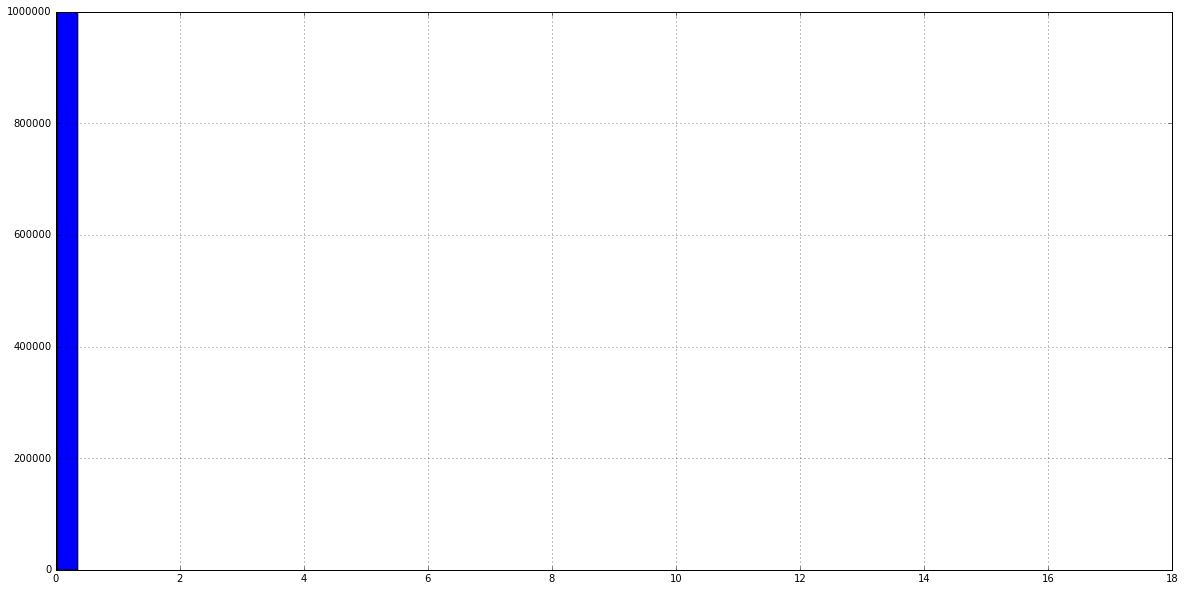

In [17]:
df.Processing.hist(grid=True, figsize=(20, 10), bins=50)

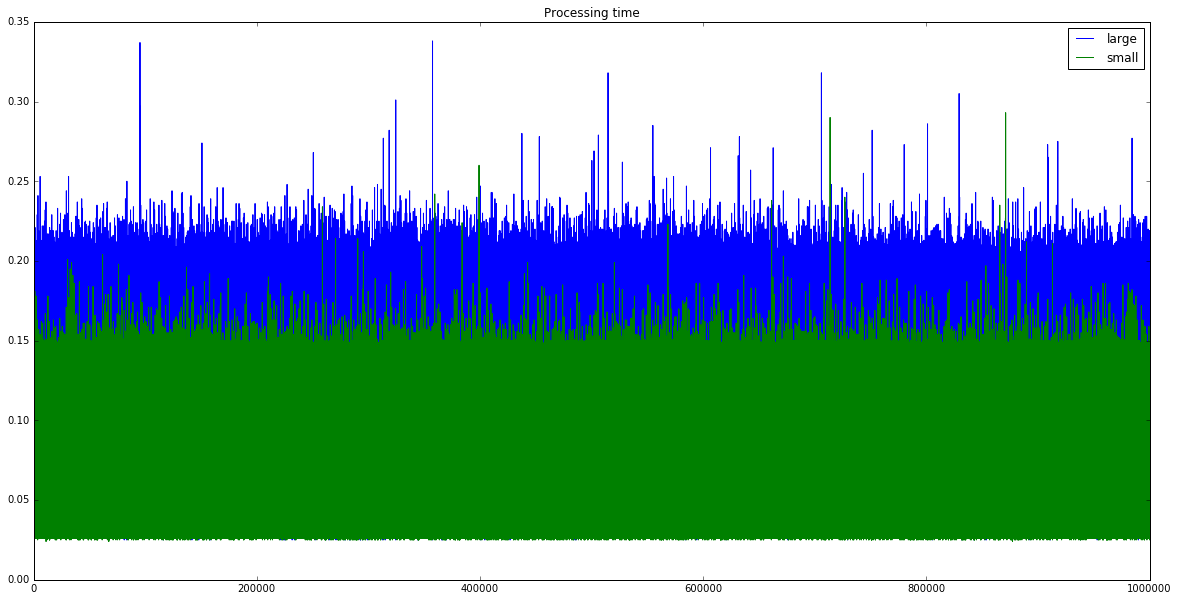

In [63]:
S = df.Processing
S = S[~((S - S.mean()).abs() > 3.5 * S.std())]

S2 = df2.Processing
S2 = S2[~((S2 - S2.mean()).abs() > 3.5 * S2.std())]

ndf = pd.DataFrame(columns=['large', 'small'])
ndf['large'] = S
ndf['small'] = S2
ndf.plot(figsize=(20, 10), title='Processing time')

In [67]:
plt.figure()
ndf.plot(kind='hist', figsize=(20, 10), bins=50, alpha=0.5)

TypeError: 'module' object is not callable

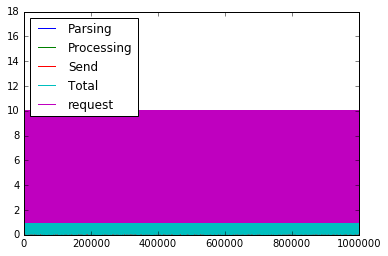

In [61]:
ndf2 = ndf.cumsum()
ndf2.plot()

In [25]:
S = df.Processing

S = S[~((S - S.mean()).abs() > 3.5 * S.std())]
df.NORM = S
df.NORM.describe(percentiles=[.25, .5, .75, 0.9, 0.99, 0.999])

count    999919.000000
mean          0.096387
std           0.045414
min           0.025000
25%           0.045000
50%           0.133000
75%           0.137000
90%           0.142000
99%           0.154000
99.9%         0.216000
max           0.338000
Name: Processing, dtype: float64

In [28]:
S = df2.Processing

S = S[~((S - S.mean()).abs() > 3.5 * S.std())]
df2.NORM = S
df2.NORM.describe(percentiles=[.25, .5, .75, 0.9, 0.99, 0.999])

count    999929.000000
mean          0.086017
std           0.043340
min           0.024000
25%           0.045000
50%           0.099000
75%           0.127000
90%           0.133000
99%           0.144000
99.9%         0.152000
max           0.293000
Name: Processing, dtype: float64

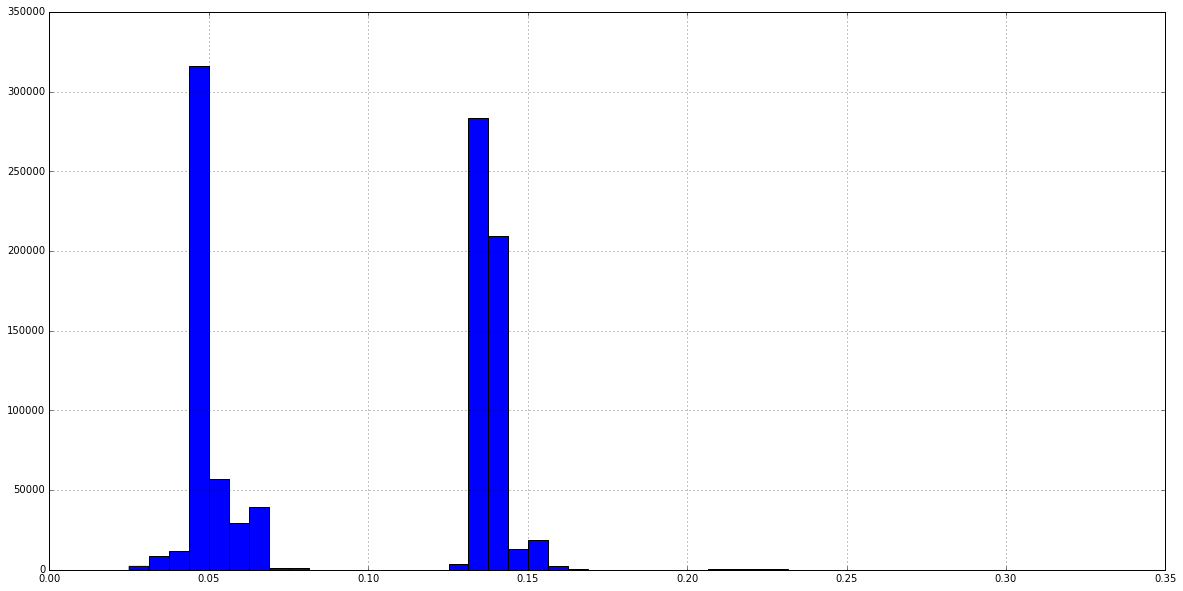

In [68]:
df.NORM.hist(grid=True, figsize=(20, 10), bins=50)